In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, roc_curve, auc, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(df,title_mapping=None,is_train=True):
    df = df.copy()  

    df = df.drop(['Ticket'], axis=1)

    df['Age'] = df['Age'].fillna(df['Age'].median())

    df["Title"] = df["Name"].str.extract(r' ([A-Za-z]+)\.')

    if is_train:
        title_mapping = df['Title'].value_counts().to_dict() 
    df['Title'] = df['Title'].map(title_mapping) 
    df['Title'] = df['Title'].fillna(0)

    df['Deck'] = df['Cabin'].astype(str).str[0] 
    df["HasCabin"] = df["Cabin"].notnull().astype(int) 

    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    df = pd.get_dummies(df, columns=['Embarked', 'Sex', 'Deck'], drop_first=False)


    df = df.drop(['Name', 'Cabin'], axis=1)

    if is_train:
        return df, title_mapping
    else:
        return df

In [14]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

X=train.dropna(axis=0,subset=['Survived'])

y = train['Survived']
train = train.drop(['Survived'], axis=1)

X, title_mapping= preprocess_data(train, is_train=True)
test = preprocess_data(test, title_mapping,is_train=False)

missing_cols = set(X.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test[X.columns] 


 Accuracy: 0.8436
 Precision: 0.8286
 Recall: 0.7838
 F1 Score: 0.8056
 ROC-AUC Score: 0.8347
 Confusion Matrix:
[[93 12]
 [16 58]]


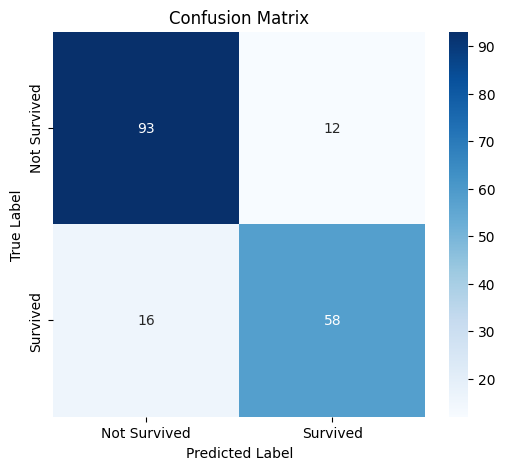

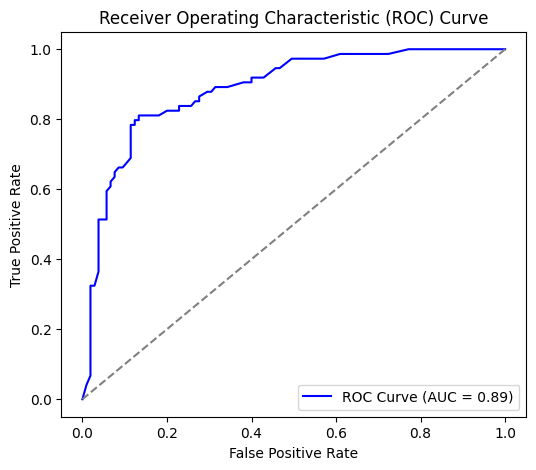

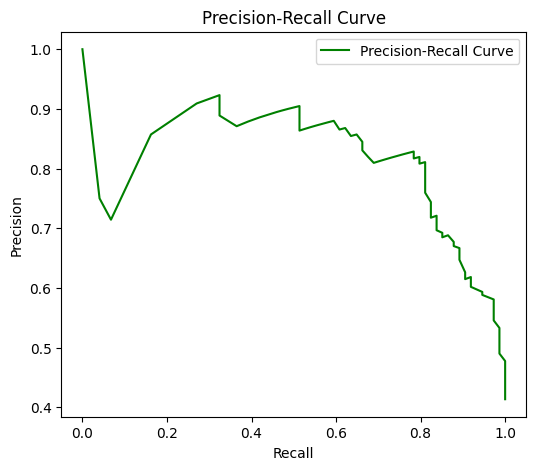

In [15]:


X_train,X_valid,y_train,y_valid=train_test_split(X,y,
                                                 train_size=0.8,test_size=0.2,random_state=42)

model=RandomForestClassifier(random_state=42,n_estimators=100)
model.fit(X_train,y_train)
preds=model.predict(X_valid)

y_valid_pred = model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_pred)
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" ROC-AUC Score: {roc_auc:.4f}")
print(f" Confusion Matrix:\n{conf_matrix}")

conf_matrix = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_valid, model.predict_proba(X_valid)[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()